In [1]:
# import some of the libaries that we will use
import urllib.request
import io
import itertools as it
import os
import zipfile
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import re
import unicodedata
import string
from collections import defaultdict
import pickle



from thefuzz import process
from thefuzz import fuzz

import json

import colorcet as cc
import panel as pn
import panel.widgets as pnw

from translate_app import translate_list_to_dict
import recordlinkage as rl
import missingno as msno
import holoviews as hv
import hvplot
import hvplot.pandas

In [2]:
# get the zip file with the data from the link


data_url = (
    "https://storage.googleapis.com/mrprimetranslator_datasets/dogs_of_zurich.zip"
)

# create function which takes the url
# retrieve zip and unzip it and return the csv files as a list


def get_data(url):
    """Function which takes in a url, retrieves the zip file,
    unzips it and returns the csv files as a list"""
    # get the zip file
    filename, headers = urllib.request.urlretrieve(url)
    with zipfile.ZipFile(filename) as zip_ref:
        # get the csv files
        dfs = []
        for file in zip_ref.namelist():
            if file.endswith(".csv"):
                csv_file = io.StringIO(zip_ref.read(file).decode("utf-8"))
                # readin csv as a pandas dataframe and append to list
                df = pd.DataFrame()
                df = pd.read_csv(csv_file)
                df["roster"] = file
                dfs.append(df)

    return dfs

In [3]:
# call the function and assign the csv files to a variable
dogs_of_zurich_dfs = get_data(data_url)

In [4]:
# Put all the column headers in one list
list_of_headings = []
for df in dogs_of_zurich_dfs:
    list_of_headings += df.columns.tolist()

more_german_words = list(
    filter(lambda x: x is not np.nan, dogs_of_zurich_dfs[3].iloc[:, 2].unique())
)
list_of_headings += more_german_words

In [5]:
# Only keep unique column headers and replace underscores with spaces

words_set = {word.replace("_", " ") for word in list_of_headings}
words_set

{'ALTER',
 'GEBURTSJAHR HUND',
 'GESCHLECHT',
 'GESCHLECHT HUND',
 'HALTER ID',
 'HUNDEFARBE',
 'HUNDERASSE',
 'HUNDERASSENTYP',
 'HUNDERASSENTYP KURZ',
 'Kleinwüchsig',
 'RASSE1',
 'RASSE1 MISCHLING',
 'RASSE2',
 'RASSE2 MISCHLING',
 'RASSENTYP',
 'Rassentypenliste I',
 'Rassentypenliste II',
 'STADTKREIS',
 'STADTQUARTIER',
 'roster'}

#### Run translate app for columns

In [6]:
translated_words = translate_list_to_dict(words_set)
translated_words

{'Rassentypenliste II': 'List of breed types II',
 'STADTQUARTIER': 'CITY QUARTER',
 'GESCHLECHT': 'GENDER',
 'HUNDERASSENTYP': 'DOG BREED TYPE',
 'GEBURTSJAHR HUND': "DOG'S YEAR OF BIRTH",
 'RASSE2 MISCHLING': 'BREED2 MIXED BREED',
 'ALTER': 'AGE',
 'RASSENTYP': 'BREED TYPE',
 'HUNDEFARBE': 'DOG COLOR',
 'HALTER ID': 'HOLDER ID',
 'HUNDERASSENTYP KURZ': 'DOG BREED TYPE SHORT',
 'Kleinwüchsig': 'Short stature',
 'RASSE2': 'BREED2',
 'GESCHLECHT HUND': 'GENDER DOG',
 'RASSE1 MISCHLING': 'BREED1 MIXED BREED',
 'roster': 'roster',
 'STADTKREIS': 'CITY CIRCLE',
 'HUNDERASSE': 'DOG BREED',
 'Rassentypenliste I': 'Breed type list I',
 'RASSE1': 'BREED1'}

In [7]:
# put the underscores back in the original headings
translated_headings_underscores = {
    key.replace(" ", "_"): value.lower().replace(" ", "_").replace("'s", "")
    for key, value in translated_words.items()
}
translated_headings_underscores

{'Rassentypenliste_II': 'list_of_breed_types_ii',
 'STADTQUARTIER': 'city_quarter',
 'GESCHLECHT': 'gender',
 'HUNDERASSENTYP': 'dog_breed_type',
 'GEBURTSJAHR_HUND': 'dog_year_of_birth',
 'RASSE2_MISCHLING': 'breed2_mixed_breed',
 'ALTER': 'age',
 'RASSENTYP': 'breed_type',
 'HUNDEFARBE': 'dog_color',
 'HALTER_ID': 'holder_id',
 'HUNDERASSENTYP_KURZ': 'dog_breed_type_short',
 'Kleinwüchsig': 'short_stature',
 'RASSE2': 'breed2',
 'GESCHLECHT_HUND': 'gender_dog',
 'RASSE1_MISCHLING': 'breed1_mixed_breed',
 'roster': 'roster',
 'STADTKREIS': 'city_circle',
 'HUNDERASSE': 'dog_breed',
 'Rassentypenliste_I': 'breed_type_list_i',
 'RASSE1': 'breed1'}

In [8]:
# This is actually translated to districts as in the 12 districts of Zurich
translated_headings_underscores["STADTKREIS"] = "district"
translated_headings_underscores["HALTER_ID"] = "owner_id"

In [9]:
# put the translated headings as the new column names
for df in dogs_of_zurich_dfs:
    df.rename(columns=translated_headings_underscores, inplace=True)

#### Get the 2 dataframes

In [10]:
# Combine 3 of 4 dataframes into one with dog owner info
dog_owner_df = pd.DataFrame()
dog_owner_df = pd.concat(
    [dogs_of_zurich_dfs[0], dogs_of_zurich_dfs[1], dogs_of_zurich_dfs[2]], axis=0
)
dog_owner_df.info()

# name last dataframe with dog breeds info
dog_df = pd.DataFrame()
dog_df = dogs_of_zurich_dfs[3]
dog_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21065 entries, 0 to 7154
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   owner_id            21065 non-null  int64  
 1   age                 21060 non-null  object 
 2   gender              21065 non-null  object 
 3   district            21060 non-null  float64
 4   city_quarter        21060 non-null  float64
 5   breed1              21065 non-null  object 
 6   breed1_mixed_breed  1939 non-null   object 
 7   breed2              1590 non-null   object 
 8   breed2_mixed_breed  0 non-null      float64
 9   breed_type          20891 non-null  object 
 10  dog_year_of_birth   21065 non-null  int64  
 11  gender_dog          21065 non-null  object 
 12  dog_color           21065 non-null  object 
 13  roster              21065 non-null  object 
dtypes: float64(3), int64(2), object(9)
memory usage: 2.4+ MB
<class 'pandas.core.frame.DataFrame'>
RangeInd

In [11]:
display(dog_owner_df.sample(3))
dog_df.sample(3)

,owner_id,age,gender,district,city_quarter,breed1,breed1_mixed_breed,breed2,breed2_mixed_breed,breed_type,dog_year_of_birth,gender_dog,dog_color,roster
91,40684,71-80,m,7.0,74.0,Labrador Retriever,NaN,NaN,NaN,I,2004,m,blondfarben,20170308hundehalter.csv
2302,90999,31-40,m,3.0,31.0,Podenco,NaN,NaN,NaN,I,2008,w,braun/rot,20170308hundehalter.csv
2996,98521,81-90,w,8.0,83.0,Dackel,Mischling,NaN,NaN,K,2004,m,rot/braun,20160307hundehalter.csv


,dog_breed,dog_breed_type_short,dog_breed_type,roster
131,English Cocker Spaniel,K,Kleinwüchsig,zuordnungstabellehunderassehundetyp.csv
93,Cimarron Uruguayo,I,Rassentypenliste I,zuordnungstabellehunderassehundetyp.csv
91,Chodsky pes,I,Rassentypenliste I,zuordnungstabellehunderassehundetyp.csv


<Axes: >

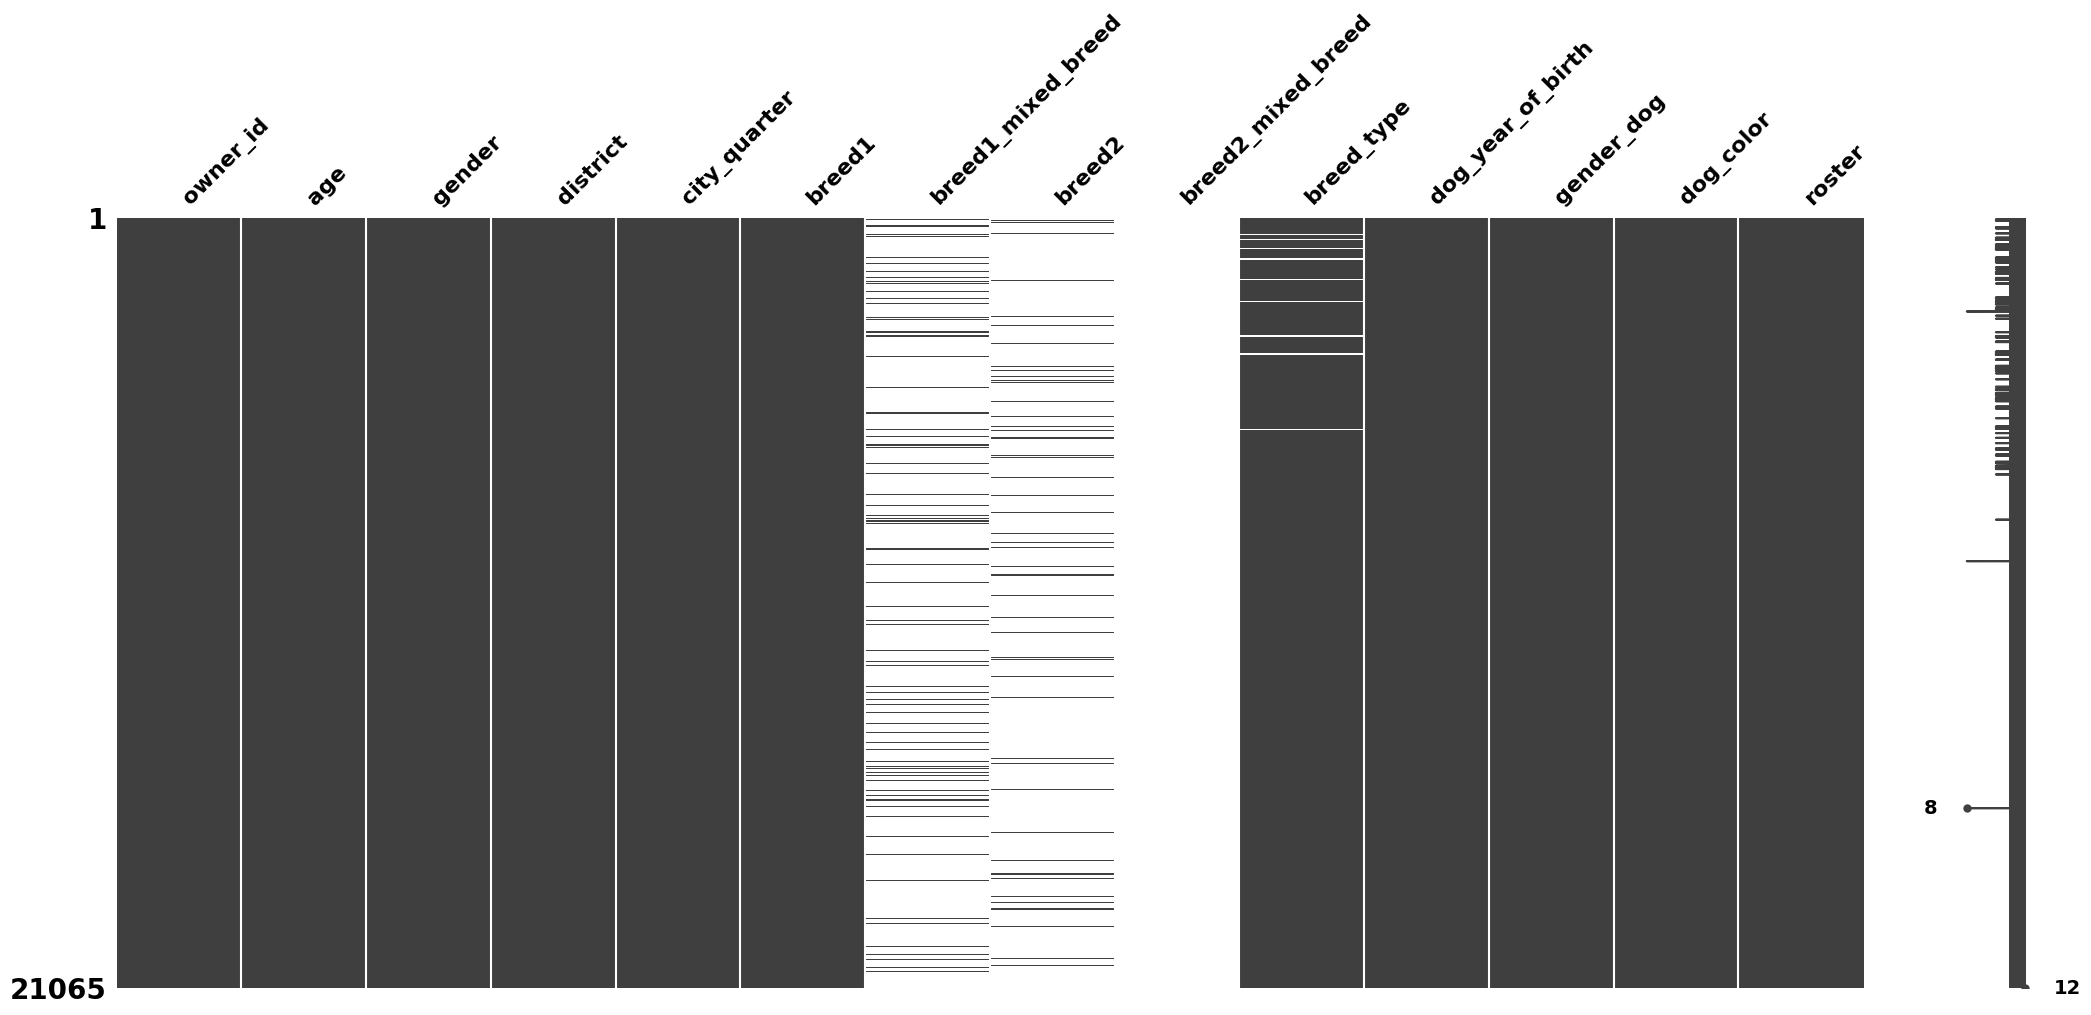

In [12]:
msno.matrix(dog_owner_df)

In [13]:
# only null values in breed2_mixed so drop column
dog_owner_df = dog_owner_df.drop(columns=["breed2_mixed_breed"])

<Axes: >

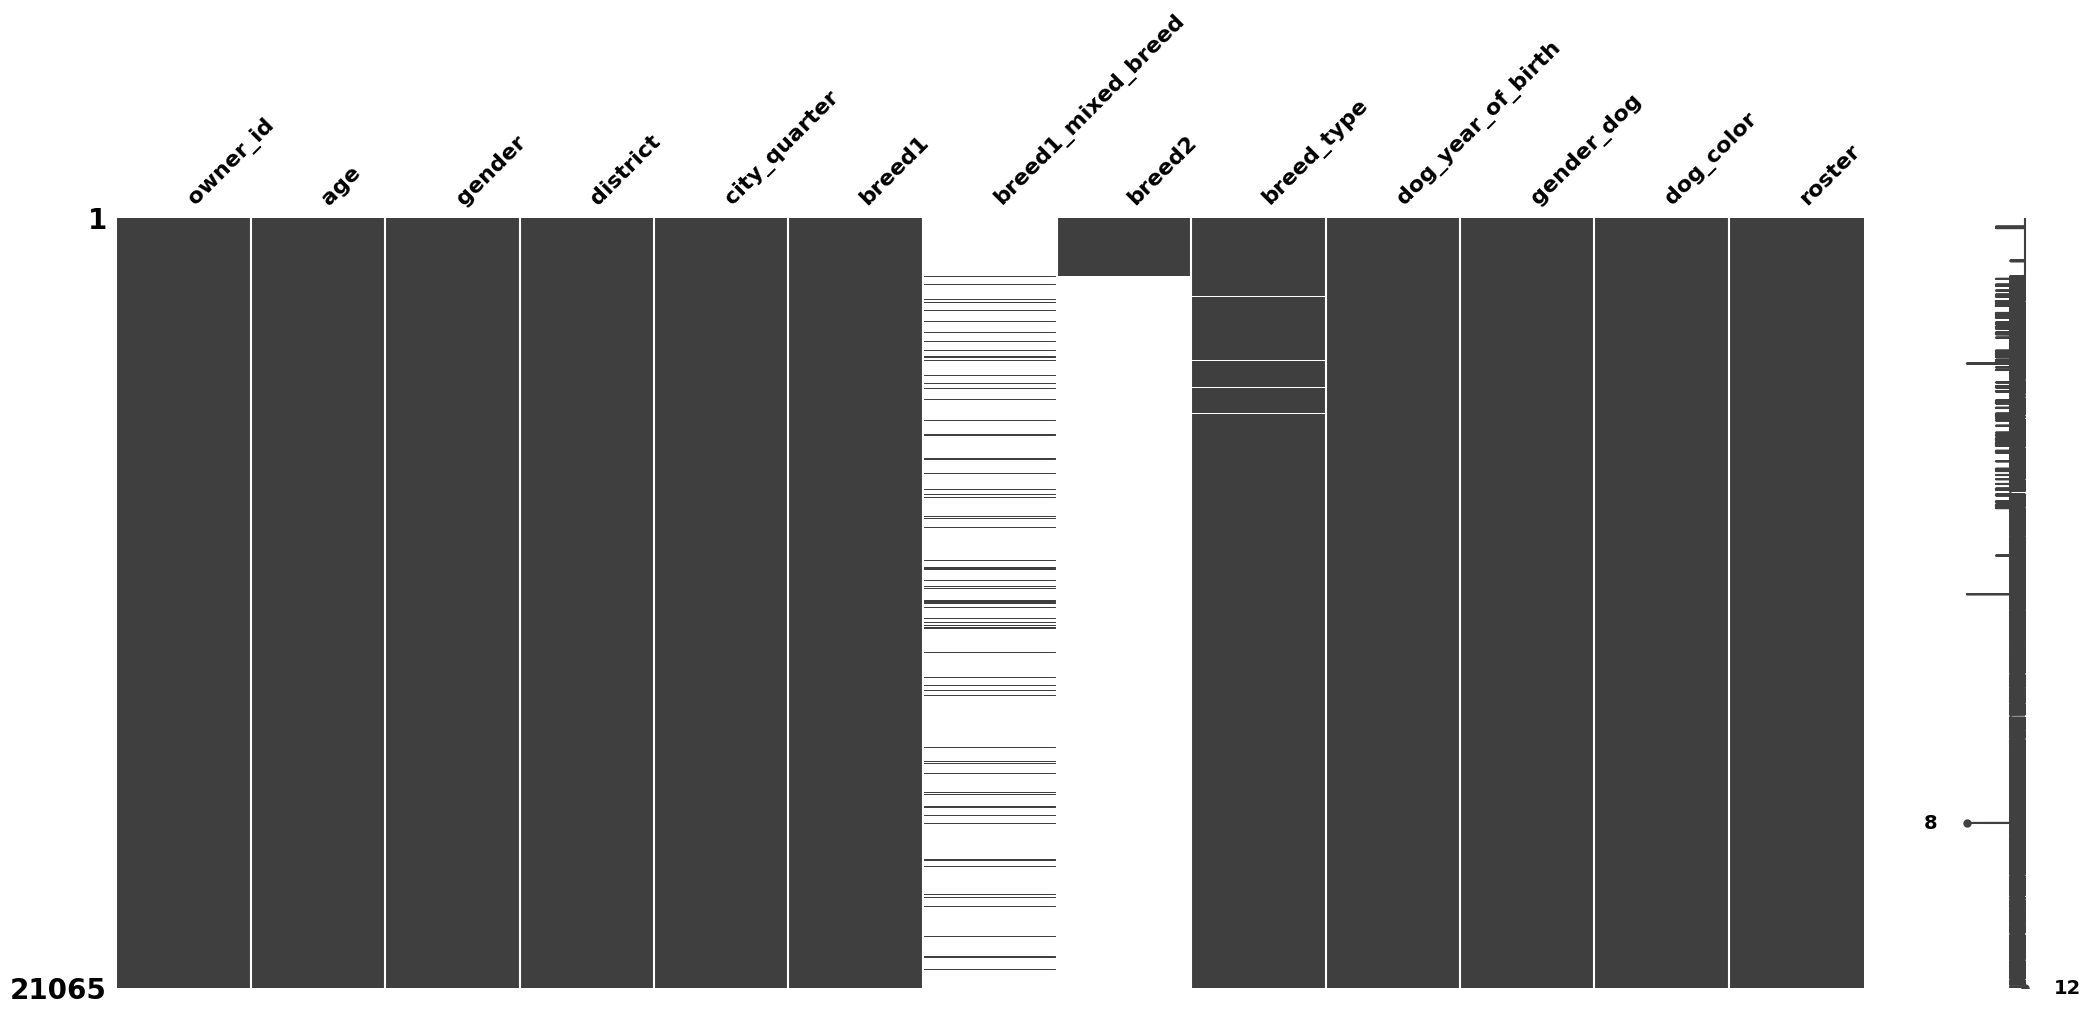

In [14]:
msno.matrix(dog_owner_df.sort_values(by=["breed2"]))

In [15]:
# reset index
dog_owner_df = dog_owner_df.reset_index(drop=True)
# make the district column a category
dog_owner_df["district"] = dog_owner_df["district"].astype("category")

# take the first 4 char of roster only and make it an ordered category colummn
dog_owner_df["roster"] = dog_owner_df["roster"].str[:4]
dog_owner_df["roster"] = pd.Categorical(dog_owner_df["roster"], ordered=True)


# add a column with the first year the owner appeared in the roster
dog_owner_df["first_appearance"] = dog_owner_df.groupby("owner_id")["roster"].transform(
    "min"
)

# add column for the numberr of appearances in the roster
dog_owner_df["appearances"] = dog_owner_df.groupby("owner_id")["roster"].transform(
    "nunique"
)

# add a column with the number of dogs per owner
dog_owner_df["dog_count"] = dog_owner_df.groupby(["owner_id", "roster"])[
    "owner_id"
].transform("size")

dog_owner_df.sample(3)

,owner_id,age,gender,district,city_quarter,breed1,breed1_mixed_breed,breed2,breed_type,dog_year_of_birth,gender_dog,dog_color,roster,first_appearance,appearances,dog_count
13674,129281,31-40,m,2.0,24.0,Malteser,NaN,NaN,K,2015,m,weiss,2016,2016,2,1
14122,80319,41-50,w,10.0,102.0,Mischling klein,NaN,NaN,K,2006,m,braun/schwarz,2017,2015,3,2
15078,85760,61-70,w,9.0,91.0,Mischling gross,NaN,NaN,I,2016,m,gestromt,2017,2015,2,1


In [16]:
# check if any row with a value in breed2 has a value in breed1_mixed_breed
dog_owner_df[dog_owner_df["breed2"].notna()]["breed1_mixed_breed"].value_counts()


# if Mischling is in breed1 then breed1_mixed_breed should be Mischling
dog_owner_df.loc[
    (dog_owner_df["breed1"].str.contains("Mischling"))
    | (dog_owner_df["breed2"].notna()),
    "breed1_mixed_breed",
] = "Mischling"

# fill in the rest with pure_breed
dog_owner_df["breed1_mixed_breed"].fillna("pure_breed", inplace=True)
dog_owner_df[dog_owner_df["breed1_mixed_breed"].isna()]

,owner_id,age,gender,district,city_quarter,breed1,breed1_mixed_breed,breed2,breed_type,dog_year_of_birth,gender_dog,dog_color,roster,first_appearance,appearances,dog_count


Dog with a year of birth after the roster year

In [17]:
# get the owner_id of the bad entries and observe other entries with the same owner_id
bad_entry_owner_id = dog_owner_df[
    dog_owner_df["dog_year_of_birth"] > dog_owner_df["roster"].astype(int)
]["owner_id"]


dog_owner_df[dog_owner_df["owner_id"].isin(bad_entry_owner_id)].sort_values(
    by="owner_id"
)

# dog_owner_df[dog_owner_df["owner_id"].isin(bad_entry_owner_id)].index

,owner_id,age,gender,district,city_quarter,breed1,breed1_mixed_breed,breed2,breed_type,dog_year_of_birth,gender_dog,dog_color,roster,first_appearance,appearances,dog_count
4543,111954,41-50,w,3.0,34.0,Parson Russell Terrier,pure_breed,NaN,K,5012,m,tricolor,2015,2015,2,1
11296,111954,51-60,w,3.0,34.0,Parson Russell Terrier,pure_breed,NaN,K,5012,m,tricolor,2016,2015,2,1
5608,121585,41-50,m,7.0,74.0,Malteser,pure_breed,NaN,K,2016,m,weiss,2015,2015,3,1
12282,121585,41-50,m,7.0,74.0,Malteser,pure_breed,NaN,K,2016,m,weiss,2016,2015,3,1
18798,121585,41-50,m,7.0,74.0,Malteser,pure_breed,NaN,K,2016,m,weiss,2017,2015,3,1


Since we have Rosters for 3 separate years, we can see if that owner corrected its wrong entry in the later years. We can drop since the bad entries are consistent with no clue as to the correct entry.

In [18]:
display(dog_owner_df.shape)

bad_entry_index = dog_owner_df[dog_owner_df["owner_id"].isin(bad_entry_owner_id)].index

dog_owner_df.drop(bad_entry_index, inplace=True)

dog_owner_df.info()

(21065, 16)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21060 entries, 0 to 21064
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   owner_id            21060 non-null  int64   
 1   age                 21055 non-null  object  
 2   gender              21060 non-null  object  
 3   district            21055 non-null  category
 4   city_quarter        21055 non-null  float64 
 5   breed1              21060 non-null  object  
 6   breed1_mixed_breed  21060 non-null  object  
 7   breed2              1590 non-null   object  
 8   breed_type          20886 non-null  object  
 9   dog_year_of_birth   21060 non-null  int64   
 10  gender_dog          21060 non-null  object  
 11  dog_color           21060 non-null  object  
 12  roster              21060 non-null  category
 13  first_appearance    21060 non-null  category
 14  appearances         21060 non-null  int64   
 15  dog_count           21060 non-null  

Dogs with a year of birth too far before the roster year (before 1990) which is plausible, but not probable

In [19]:
# get the owner_id of the bad entries
bad_entry_owner_id = dog_owner_df[dog_owner_df["dog_year_of_birth"] < 1990]["owner_id"]

# isolate entries from these owner_ids and group them by owner_id
dog_owner_group = (
    dog_owner_df[dog_owner_df["owner_id"].isin(bad_entry_owner_id)]
    .sort_values(by="owner_id")
    .groupby("owner_id")
)

dog_owner_df[dog_owner_df["owner_id"].isin(bad_entry_owner_id)].sort_values(
    by="owner_id"
)

,owner_id,age,gender,district,city_quarter,breed1,breed1_mixed_breed,breed2,breed_type,dog_year_of_birth,gender_dog,dog_color,roster,first_appearance,appearances,dog_count
2659,91351,41-50,m,7.0,72.0,Mops,pure_breed,NaN,K,1980,w,beige/schwarz,2015,2015,3,1
9485,91351,41-50,m,7.0,72.0,Mops,pure_breed,NaN,K,2009,w,beige/schwarz,2016,2015,3,1
16238,91351,41-50,m,7.0,72.0,Mops,pure_breed,NaN,K,2009,w,beige/schwarz,2017,2015,3,1
2901,94655,41-50,w,2.0,24.0,Labrador Retriever,pure_breed,NaN,I,8,w,braun,2015,2015,3,1
9712,94655,41-50,w,2.0,24.0,Labrador Retriever,pure_breed,NaN,I,2008,w,braun,2016,2015,3,1
16448,94655,41-50,w,2.0,24.0,Labrador Retriever,pure_breed,NaN,I,2008,w,braun,2017,2015,3,1
3165,98411,71-80,w,11.0,119.0,Labrador Retriever,pure_breed,NaN,I,1,w,schwarz,2015,2015,3,1
9966,98411,71-80,w,11.0,119.0,Labrador Retriever,pure_breed,NaN,I,2001,w,schwarz,2016,2015,3,1
16689,98411,71-80,w,11.0,119.0,Labrador Retriever,pure_breed,NaN,I,2001,w,schwarz,2017,2015,3,1
3521,100070,51-60,w,9.0,92.0,Pekingese,pure_breed,NaN,K,1962,m,braun/schwarz,2015,2015,3,1


We can replace bad entries with matching entries from the later roster years as the owner corrected the value for th elater rosters. Luckly these owners only have one dog each.

The one bad entry of `1980` with only 1 appearance we cannot safely replace so we drop it(`owner_id` 129251).

In [20]:
# these entries only have 1 dog so we can replace the year of birth with the mode making some assumptions
dog_owner_df.loc[
    dog_owner_df["owner_id"].isin(bad_entry_owner_id), "dog_year_of_birth"
] = dog_owner_group["dog_year_of_birth"].transform(lambda x: x.mode().iloc[0])

dog_owner_df[dog_owner_df["owner_id"].isin(bad_entry_owner_id)].sort_values(
    by="owner_id"
)

,owner_id,age,gender,district,city_quarter,breed1,breed1_mixed_breed,breed2,breed_type,dog_year_of_birth,gender_dog,dog_color,roster,first_appearance,appearances,dog_count
2659,91351,41-50,m,7.0,72.0,Mops,pure_breed,NaN,K,2009,w,beige/schwarz,2015,2015,3,1
9485,91351,41-50,m,7.0,72.0,Mops,pure_breed,NaN,K,2009,w,beige/schwarz,2016,2015,3,1
16238,91351,41-50,m,7.0,72.0,Mops,pure_breed,NaN,K,2009,w,beige/schwarz,2017,2015,3,1
2901,94655,41-50,w,2.0,24.0,Labrador Retriever,pure_breed,NaN,I,2008,w,braun,2015,2015,3,1
9712,94655,41-50,w,2.0,24.0,Labrador Retriever,pure_breed,NaN,I,2008,w,braun,2016,2015,3,1
16448,94655,41-50,w,2.0,24.0,Labrador Retriever,pure_breed,NaN,I,2008,w,braun,2017,2015,3,1
3165,98411,71-80,w,11.0,119.0,Labrador Retriever,pure_breed,NaN,I,2001,w,schwarz,2015,2015,3,1
9966,98411,71-80,w,11.0,119.0,Labrador Retriever,pure_breed,NaN,I,2001,w,schwarz,2016,2015,3,1
16689,98411,71-80,w,11.0,119.0,Labrador Retriever,pure_breed,NaN,I,2001,w,schwarz,2017,2015,3,1
3521,100070,51-60,w,9.0,92.0,Pekingese,pure_breed,NaN,K,2006,m,braun/schwarz,2015,2015,3,1


In [21]:
# the one with only 1 appearance we cannot safely replace so we drop it
dog_owner_df = dog_owner_df.drop(dog_owner_df[dog_owner_df["owner_id"] == 129251].index)

# No more 20/30something years-old dogs
dog_owner_df[dog_owner_df["dog_year_of_birth"] < 1990]["owner_id"]

Series([], Name: owner_id, dtype: int64)

Add 1 to the dog age so that no dog has an age of 0. Consider it the dog's year of living.

In [22]:
# dog's age is calculated by subtracting the year of birth from the year of the roster
# added 1 in case i wanted to do something with log down the line
dog_owner_df["dog_age"] = (
    dog_owner_df["roster"].astype(int) - dog_owner_df["dog_year_of_birth"] + 1
)


def dog_stage(age):
    """Function to categorize dog's age into stages"""
    if age <= 3:
        return "puppy"

    elif age <= 8:
        return "adult"
    elif age > 8:
        return "senior"
    else:
        return "no age given"


dog_owner_df["dog_stage"] = dog_owner_df["dog_age"].apply(dog_stage)
dog_owner_df.sample(3)
# dog_owner_df[dog_owner_df["owner_id"] == 135329]
dog_owner_df.groupby(["dog_stage", "roster"])["dog_stage"].count()

dog_stage  roster
adult      2015      2819
           2016      2865
           2017      2897
puppy      2015      1335
           2016       956
           2017      1047
senior     2015      2824
           2016      3106
           2017      3210
Name: dog_stage, dtype: int64

In [23]:
query_breed = r"bull"
breed_age_max_df = dog_owner_df.groupby(
    ["breed1", "breed1_mixed_breed"], as_index=False, sort=True
)["dog_age"].max()
breed_age_max_df[
    breed_age_max_df["breed1"].str.contains(query_breed, regex=True, case=False)
]

,breed1,breed1_mixed_breed,dog_age
11,American Bulldog,pure_breed,14
94,Bull Terrier,pure_breed,4
95,Bulldog,Mischling,11
96,Bulldog,pure_breed,15
97,Bullmastiff,pure_breed,7
123,Continental Bulldog,Mischling,9
124,Continental Bulldog,pure_breed,13
160,Englische Bulldogge,pure_breed,12
183,Französische Bulldogge,Mischling,6
184,Französische Bulldogge,pure_breed,15


In [24]:
# get the breeds for which there is a mixed breed but no pure breed
mixed_df = dog_owner_df[dog_owner_df["breed1_mixed_breed"] == "Mischling"]
print(f"Mixed dataframe shape: {mixed_df.shape}")

pure_df = dog_owner_df[dog_owner_df["breed1_mixed_breed"] == "pure_breed"]
print(f"Pure dataframe shape: {pure_df.shape}")

mixed_breeds = set(
    dog_owner_df[dog_owner_df["breed1_mixed_breed"] == "Mischling"]["breed1"].values
)
pure_breeds = set(
    dog_owner_df[dog_owner_df["breed1_mixed_breed"] == "pure_breed"]["breed1"].values
)
mixed_breeds - pure_breeds
len(mixed_breeds)
len(pure_breeds)

Mixed dataframe shape: (5913, 18)
Pure dataframe shape: (15146, 18)


296

In [25]:
dog_owner_df["age"].value_counts()

51-60     4558
41-50     4468
31-40     3941
61-70     3095
21-30     2337
71-80     1957
81-90      524
11-20      127
91-100      47
Name: age, dtype: int64

In [27]:
display(dog_owner_df[dog_owner_df.age.isnull()])


# Drop these 5 rows with unknown
dog_owner_df["age"].fillna("0", inplace=True)
dog_owner_df.dropna(subset=["age"], inplace=True)
dog_owner_df.shape

,owner_id,age,gender,district,city_quarter,breed1,breed1_mixed_breed,breed2,breed_type,dog_year_of_birth,gender_dog,dog_color,roster,first_appearance,appearances,dog_count,dog_age,dog_stage


(21059, 18)

In [28]:
# owners each year
owner_2015 = set(dog_owner_df[dog_owner_df["roster"] == "2015"]["owner_id"])
owner_2016 = set(dog_owner_df[dog_owner_df["roster"] == "2016"]["owner_id"])
owner_2017 = set(dog_owner_df[dog_owner_df["roster"] == "2017"]["owner_id"])

print(f"{len(owner_2015)} initial owners in 2015")
# constant owners for all 3 years
new_2016 = owner_2016.difference(owner_2015)
returning_2016 = owner_2016.intersection(owner_2015)
print(f"{len(new_2016)} new owners in 2016 and {len(returning_2016)} returning owners")

new_2017 = owner_2017.difference(owner_2015.union(owner_2016))
returning_2017 = owner_2017.intersection(owner_2015.union(owner_2016))
print(f"{len(new_2017)} new owners in 2017 and {len(returning_2017)} returning owners")

constistent_owners = owner_2015.intersection(owner_2016).intersection(owner_2017)
print(f"{len(constistent_owners)} constant owners")

6314 initial owners in 2015
434 new owners in 2016 and 5838 returning owners
975 new owners in 2017 and 5472 returning owners
5075 constant owners


In [29]:
dog_owner_df["age"] = pd.Categorical(
    dog_owner_df["age"],
    ordered=True,
    categories=[
        "0",
        "11-20",
        "21-30",
        "31-40",
        "41-50",
        "51-60",
        "61-70",
        "71-80",
        "81-90",
        "91-100",
    ],
)


# dog_owner_df.plot(
#     kind="bar",
#     column="age",
#     by="roster",
#     bins=9,
#     figsize=(10, 5),
#     histtype="step",
# )
dog_owner_df.groupby(
    [
        "age",
        "roster",
    ]
).size().unstack().hvplot.bar(
    xlabel="",
    rot=90,
    legend=True,
    tools=["hover", "box_select"],
    title="Owners age distribution each roster",
)

:Bars   [age,roster]   (value)

In [30]:
def age_group(age):
    """Function which widen the age groups of the oldest and youngest dog owners"""
    if age == "71-80" or age == "81-90" or age == "91-100":
        return "71+"
    elif age == "11-20" or age == "21-30":
        return "11-30"

    else:
        return age


dog_owner_df["age_group"] = dog_owner_df["age"].apply(age_group).dropna()
dog_owner_df

,owner_id,age,gender,district,city_quarter,breed1,breed1_mixed_breed,breed2,breed_type,dog_year_of_birth,gender_dog,dog_color,roster,first_appearance,appearances,dog_count,dog_age,dog_stage,age_group
0,126,51-60,m,9.0,92.0,Welsh Terrier,pure_breed,NaN,K,2011,w,schwarz/braun,2015,2015,3,1,5,adult,51-60
1,574,61-70,w,2.0,23.0,Cairn Terrier,pure_breed,NaN,K,2002,w,brindle,2015,2015,3,1,14,senior,61-70
2,695,41-50,m,6.0,63.0,Labrador Retriever,pure_breed,NaN,I,2012,w,braun,2015,2015,3,1,4,adult,41-50
3,893,61-70,w,7.0,71.0,Mittelschnauzer,pure_breed,NaN,I,2010,w,schwarz,2015,2015,3,1,6,adult,61-70
4,1177,51-60,m,10.0,102.0,Shih Tzu,pure_breed,NaN,K,2011,m,schwarz/weiss,2015,2015,3,1,5,adult,51-60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21060,135718,31-40,m,9.0,91.0,Mischling gross,Mischling,NaN,I,2015,w,golden,2017,2017,1,1,3,puppy,31-40
21061,135725,31-40,w,7.0,74.0,Boxer,pure_breed,NaN,I,2016,w,gelb/weiss,2017,2017,1,1,2,puppy,31-40
21062,135726,11-20,w,11.0,111.0,Pinscher,pure_breed,NaN,K,2016,w,schwarz,2017,2017,1,1,2,puppy,11-30
21063,135728,31-40,w,7.0,72.0,Whippet,pure_breed,NaN,I,2016,w,vierfarbig,2017,2017,1,1,2,puppy,31-40


In [31]:
dog_owner_df["age_range"] = dog_owner_df["age"].str[:1] + "0s"

In [32]:
print(
    f"Number of null values in column 'breed_type': ",
    dog_owner_df.breed_type.isnull().sum(),
)

# get the breed1 for the entries with missing breed_type
breed_missing_breed_type = dog_owner_df[dog_owner_df["breed_type"].isnull()][
    "breed1"
].unique()

breed_missing_breed_type

Number of null values in column 'breed_type':  174


array(['Terrier', 'Pudel', 'Miniature Australien Shepard', 'Elo',
       'Dogo Canario', 'Schwedischer Vallhund', 'Spaniel', 'Daisy-Dog',
       'Deutscher Jagdterrier', 'Biewer Yorkshire Terrier'], dtype=object)

In [33]:
dog_owner_df.groupby(["breed_type", "roster"]).size().unstack().hvplot.bar(
    xlabel="",
    rot=90,
    legend=True,
    tools=["hover", "box_select"],
    title="Breed type distribution each roster",
)

:Bars   [breed_type,roster]   (value)

In [34]:
pd.set_option("display.max_rows", 100)
bully_breed = dog_owner_df[dog_owner_df.breed_type == "II"]["breed1"].unique().tolist()
dog_owner_df[dog_owner_df.breed1.isin(bully_breed)]
dog_owner_df[dog_owner_df.breed_type == "II"].sort_values(
    by="dog_count", ascending=False
)["owner_id"].nunique()

# bully_pattern = re.compile(r"[P|p]it\s?[B|b]ull|Staffordshire")

# dog_owner_df[
#     dog_owner_df["breed1"].str.contains(bully_pattern, na=False)
#     | dog_owner_df["breed2"].str.contains(bully_pattern, na=False)
# ]

27

In [35]:
# Find these breeds in the dog_df and get the breed_type from there
dog_df.drop("roster", axis=1, inplace=True)
dog_df[dog_df["dog_breed"].isin(breed_missing_breed_type)]

,dog_breed,dog_breed_type_short,dog_breed_type
55,Biewer Yorkshire Terrier,NaN,NaN
104,Daisy-Dog,NaN,NaN
112,Deutscher Jagdterrier,NaN,NaN
124,Dogo Canario,NaN,NaN
126,Elo,NaN,NaN
221,Miniature Australien Shepard,NaN,NaN
269,Pudel,NaN,NaN
291,Schwedischer Vallhund,NaN,NaN
311,Spaniel,NaN,NaN
320,Terrier,NaN,NaN


In [36]:
# see what other dogs of these breeds have as breed_type
dog_owner_df[dog_owner_df["breed1"].isin(breed_missing_breed_type)].sort_values(
    by=["breed1", "owner_id"]
)

dog_breed_group = dog_owner_df[
    dog_owner_df["breed1"].isin(breed_missing_breed_type)
].groupby("breed1")

# most breeds have a unanimous breed_type so we can just fillna with the mode
display(dog_breed_group["breed_type"].value_counts())


# Fill in the missing breed_type with the mode of the breed1
dog_owner_df["breed_type"].fillna(
    dog_owner_df.groupby("breed1")["breed_type"].transform(lambda x: x.mode().iloc[0]),
    inplace=True,
)

dog_owner_df.info()

breed1                        breed_type
Biewer Yorkshire Terrier      K              20
Daisy-Dog                     K               2
Deutscher Jagdterrier         K               4
Dogo Canario                  I               7
Elo                           I               3
Miniature Australien Shepard  K              14
Pudel                         K             216
                              I               5
Schwedischer Vallhund         K               2
Spaniel                       K              13
Terrier                       K             123
                              I               2
Name: breed_type, dtype: int64

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21059 entries, 0 to 21064
Data columns (total 20 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   owner_id            21059 non-null  int64   
 1   age                 21059 non-null  category
 2   gender              21059 non-null  object  
 3   district            21054 non-null  category
 4   city_quarter        21054 non-null  float64 
 5   breed1              21059 non-null  object  
 6   breed1_mixed_breed  21059 non-null  object  
 7   breed2              1590 non-null   object  
 8   breed_type          21059 non-null  object  
 9   dog_year_of_birth   21059 non-null  int64   
 10  gender_dog          21059 non-null  object  
 11  dog_color           21059 non-null  object  
 12  roster              21059 non-null  category
 13  first_appearance    21059 non-null  category
 14  appearances         21059 non-null  int64   
 15  dog_count           21059 non-null  

In [37]:
missing_district_owner_id = dog_owner_df[dog_owner_df["district"].isna()][
    "owner_id"
].unique()

dog_owner_df[dog_owner_df["owner_id"].isin(missing_district_owner_id)]

# drop these missing rows with no district info
# dog_owner_df.dropna(subset=["district"], inplace=True)

# dog_owner_df.info()
dog_owner_df[dog_owner_df["owner_id"] == 6364]

,owner_id,age,gender,district,city_quarter,breed1,breed1_mixed_breed,breed2,breed_type,dog_year_of_birth,gender_dog,dog_color,roster,first_appearance,appearances,dog_count,dog_age,dog_stage,age_group,age_range
36,6364,61-70,m,NaN,NaN,Appenzeller,Mischling,Border Collie,I,2013,m,tricolor,2015,2015,2,1,3,puppy,61-70,60s
7014,6364,61-70,m,NaN,NaN,Appenzeller,Mischling,Border Collie,I,2013,m,tricolor,2016,2015,2,1,4,adult,61-70,60s


In [38]:
# Convert the string columns to lower case
breed_columns = ["breed1", "breed2", "breed1_mixed_breed", "breed_type"]
# for col in breed_columns:
#     dog_owner_df[col] = dog_owner_df[col].str.lower()

dog_owner_df.sample(3)

,owner_id,age,gender,district,city_quarter,breed1,breed1_mixed_breed,breed2,breed_type,dog_year_of_birth,gender_dog,dog_color,roster,first_appearance,appearances,dog_count,dog_age,dog_stage,age_group,age_range
17617,108023,41-50,w,10.0,101.0,Chihuahua,pure_breed,NaN,K,2011,w,schwarz/braun/weiss,2017,2015,3,1,7,adult,41-50,40s
19882,128238,51-60,w,10.0,101.0,Bergamasker,Mischling,Hovawart,I,2015,w,schwarz/braun,2017,2015,3,1,3,puppy,51-60,50s
15352,87307,31-40,w,6.0,61.0,Border Collie,Mischling,NaN,I,2009,w,schwarz/weiss,2017,2015,3,2,9,senior,31-40,30s


In [39]:
dog_owner_df["breed1_mixed_breed"].unique()
dog_owner_df["breed1_mixed_breed"].nunique()
dog_owner_df[breed_columns].describe()
# dog_df["dog_breed"].unique()
dog_owner_df["breed1"].dropna().unique().tolist()

['Welsh Terrier',
 'Cairn Terrier',
 'Labrador Retriever',
 'Mittelschnauzer',
 'Shih Tzu',
 'Dackel',
 'Bichon frisé',
 'Zwergdackel',
 'Bergamasker',
 'Border Collie',
 'Pinscher',
 'Chihuahua',
 'West Highland White Terrier',
 'Mischling klein',
 'Golden Retriever',
 'Weimaraner',
 'Tibetan Spaniel',
 'Leonberger',
 'Shiba Inu',
 'Beagle',
 'Lagotto Romagnolo',
 'Border Terrier',
 'Magyar Viszla',
 'Prager Rattler',
 'Französische Bulldogge',
 'Cocker Spaniel',
 'Zwergrauhaardackel',
 'Jack Russel Terrier',
 'Mops',
 'Appenzeller',
 'Staffordshire Bull Terrier',
 'Grosspudel',
 'Spitz',
 'Englische Bulldogge',
 'English Springer Spaniel',
 'Malteser',
 'Dobermann',
 'Langhaardackel',
 'Husky',
 'Bolonka Zwetna',
 'Kleinspitz',
 'Toypudel',
 'Terrier',
 'Berger blanc Suisse',
 'Zwergpudel',
 'Foxterrier',
 'Kooiker',
 'Mittelpudel',
 'Yorkshire Terrier',
 'Boxer',
 'Pudel',
 'Belgischer Schäfer',
 'Deutscher Schäfer',
 'Berner Sennenhund',
 'Chow Chow',
 'Mudi',
 'Papillon',
 'Dachsh

In [40]:
# get all of the dog breeds to translate and put in a list
breed_list1 = dog_owner_df[["breed1", "breed2"]].stack().dropna().unique().tolist()
breed_list2 = dog_df["dog_breed"].unique().tolist()
breed_list3 = list(
    filter(lambda x: x is not np.nan, dog_owner_df["breed1_mixed_breed"].unique())
)
print(f"Length of breed_list1: {len(breed_list1)}")
print(f"Length of breed_list2: {len(breed_list2)}")


only_in_breed2 = set(breed_list2).difference(set(breed_list1))
print(f"Length of only_in_breed2: {len(only_in_breed2)}")
print(only_in_breed2)
breed_set = set(breed_list1 + breed_list2)
len(breed_set)
# breed_set
unmatched_breeds_df = pd.DataFrame()
unmatched_breeds_df["breed"] = list(breed_set)
unmatched_breeds_df
unmatched_breeds_df[
    unmatched_breeds_df["breed"].str.contains(
        "Mischling|klein|gross", regex=True, case=False
    )
]

Length of breed_list1: 314
Length of breed_list2: 360
Length of only_in_breed2: 49
{'Australian working Kelpie', 'Iberischer Laufhund', 'Hannoverscher', 'Englischer', 'Elo gross', 'Foo Dog klein', 'Tamaskan', 'Braque', 'Italienischer Laufhund', 'Kanadischer Schäfer', 'Trüffelhund', 'Bullterrier', 'Kaukasischer Schäfer', 'American Akita', 'German Shepard', 'Bluthund', 'Puli Ungarischer Hirtenhund', 'Fuchs Terrier', 'Västgötaspets', 'lunde', 'Elo klein', 'Broholmer', 'Bichon à poil frisé', 'Old English Mastiff', 'Red Heeler', 'Kanaan', 'Polarspitz', 'Pon Hirtenhund', 'American Pit Bull Terrier', 'Danish-Swedish Farmdog', 'Old English  Sheepdog', 'Petit bleu de Gascogne', 'Bedlington Terrier', 'Mastino Napoletano', 'Deutscher Langhaarvorstehhund', 'Westfalenterrier', 'Dürbächler', 'Luzerner Niederlaufhund', 'Basset Fauve de Bretagne', 'Stabijhoun', 'Anatolian Kangal', 'Langhaarschäfer', 'Italienische Bracke', 'Barzoi', 'Boxer Terrier', 'Bichon Löwenherz', 'Portugiesischer Hirtenhund', 'La

,breed
98,Grosspudel
120,Mischling klein
200,Foo Dog klein
244,Deutscher Grossspitz
265,Mischling gross
286,Elo klein
324,Elo gross
332,Kleinspitz
343,Foo Dog gross
362,Kleiner Münsterländer


In [41]:
breed_dict = defaultdict(list)
set(breed_list1)

{'Affenpinscher',
 'Afghane',
 'Afghanischer Windhund',
 'Airedale Terrier',
 'Akita Inu',
 'Alano',
 'Alaskan Malamute',
 'Alpenländische Dachsbracke',
 'Altdeutscher Hütehund',
 'Altdeutscher Schäfer',
 'American Bulldog',
 'American Cocker Spaniel',
 'American Pitbull Terrier',
 'American Staffordshire Terrier',
 'Anatolischer Hirtenhund',
 'Appenzeller',
 'Appenzeller Sennenhund',
 'Australian Cattle Dog',
 'Australian Shepherd',
 'Australian Silky Terrier',
 'Australian Terrier',
 'Australien Kelpie',
 'Azawakh',
 'Barbet',
 'Bardino',
 'Basenji',
 'Basset',
 'Basset Griffon vendéen',
 'Basset Hound',
 'Bayerischer Gebirgsschweisshund',
 'Beagle',
 'Bearded Collie',
 'Beauceron',
 'Beauceron Berge de Beauce',
 'Belgischer Schäfer',
 'Bergamasker',
 'Berger Picard',
 'Berger blanc Suisse',
 'Berger de Beauce',
 'Berger de Brie',
 'Berger des Pyrenées',
 'Berner Sennenhund',
 'Bernhardiner',
 'Bichon',
 'Bichon Havanais',
 'Bichon frisé',
 'Bichon maltais',
 'Biewer Yorkshire Terrie

In [ ]:
# breed_list1 = ["Pitbull", "German Shepherd", "Golden Retriever"]
# breed_list2 = ["Labrador Retriever", "Poodle", "Pit Bull"]

bully_pattern = re.compile(r"[P|p]it\s?[B|b]ull")
russel_pattern = re.compile(r"([P|p]arson|[J|j]ack|[R|r]ussel[l]?)+")

list(filter(bully_pattern.findall, sorted(breed_set)))
list(filter(russel_pattern.findall, sorted(breed_set)))

#### Get the AKC breeds saved to disk

In [43]:
# get the dog_breeds dataframe from the data folder
akc_breeds_df = pd.read_csv("../data/akc_dog_breeds.csv")
akc_breeds_df = akc_breeds_df.rename(columns={"breed": "akc_breed"})
# akc_dog_breeds.sample(3)

fci_breeds_df = pd.read_csv("../data/fci_breeds_trans.csv")
fci_breeds_df

with open("../data/breed_standards.pkl", "rb") as f:
    breed_standards = pickle.load(f)
breed_standards

# breed_choices = (
#     akc_breeds_df["akc_breed"].tolist() + fci_breeds_df["breed_en"].tolist()
# )
# breed_choices = list(set(breed_choices))
# breed_choices_df = pd.DataFrame(breed_choices, columns=["breed"])
# # breed_choices_df

{'AFFENPINSCHER': {'affenpinscher'},
 'AFGHAN HOUND': {'afghan hound',
  'afghanischer windhund',
  'lebrel afgano',
  'levrier afghan'},
 'ATLAS MOUNTAIN DOG (AIDI)': {'atlas mountain dog (aidi)',
  'atlas-berghund (aïdi)',
  "aïdi (chien de montagne de l'atlas)",
  "chien de montagne de l'atlas (aïdi)",
  'perro de montaña del atlas (aïdi)'},
 'AIREDALE TERRIER': {'airedale terrier'},
 'AKITA': {'akita'},
 'ALASKAN MALAMUTE': {'alaskan malamute',
  'malamute de alaska',
  "malamute de l'alaska"},
 'ALPINE DACHSBRACKE': {'alpenländische dachsbracke',
  'alpine dachsbracke',
  'basset des alpes',
  'dachsbracke de los alpes'},
 'AMERICAN AKITA': {'akita americain',
  'akita americano',
  'american akita',
  'amerikanischer akita'},
 'AMERICAN COCKER SPANIEL': {'american cocker spaniel',
  'amerikanischer cocker spaniel',
  'cocker américain',
  'cocker spaniel',
  'cocker spaniel americano'},
 'AMERICAN FOXHOUND': {'american foxhound'},
 'AMERICAN STAFFORDSHIRE TERRIER': {'american sta

In [ ]:
pd.set_option("display.max_rows", 200)


def remove_accents(input_str):
    """Function to remove accents from a string.
    It takes as argument a string and returns the same string
    without accents."""
    nfkd_form = (
        unicodedata.normalize("NFKD", input_str).encode("ASCII", "ignore").decode()
    )
    # return "".join([c for c in nfkd_form if not unicodedata.combining(c)])
    return nfkd_form


remove_accents("résuméö")

In [ ]:
punc = string.punctuation.replace(",", "").replace("-", "")  # + "’"

pd.options.display.max_colwidth = 100

fci_breeds_df["alt_names"] = (
    fci_breeds_df["breed"]
    + " , "
    + fci_breeds_df["translations"]
    .str.replace(rf"[{punc}]", "", regex=True)
    .str.strip()
    + " , "
    + fci_breeds_df["translations"]
    .apply(remove_accents)
    .str.replace(rf"[{punc}]", "", regex=True)
    .str.strip()
)
fci_breeds_df["alt_names"] = (
    fci_breeds_df["alt_names"]
    .str.lower()
    .str.split(",")
    .apply(lambda x: [i.strip() for i in x])
)


fci_breeds_df["alt_names"] = fci_breeds_df["alt_names"].transform(set)

dog_breeds = defaultdict(set)

for idx, breed_set in fci_breeds_df[["alt_names"]].iterrows():
    for breed in breed_set[0]:
        dog_breeds[breed].add(fci_breeds_df.iloc[idx, 0])
m = n = 0
for breed in set(breed_list1):
    if breed.lower() in dog_breeds:
        print(breed, dog_breeds[breed.lower()])
        m += 1
    else:
        print(breed, "not found")
        n += 1
print(m, n)

In [ ]:
breed_set = {breed.lower() for breed in breed_set}
breed_to_trans = {breed: [] for breed in breed_set}

for index, row in enumerate(fci_breeds_df["alt_names"]):
    for item in row.intersection(breed_set):
        breed_to_trans[item] = row

matches_df = pd.DataFrame.from_dict(breed_to_trans, orient="index").reset_index()
# matches_df.columns = ["breed", "index_match"]
breed_to_trans

In [44]:
def match_breed_name(name, choices, scorer=fuzz.token_sort_ratio):
    mismo, score, *_ = process.extractOne(name, choices, scorer=scorer)
    return mismo, score

In [ ]:
match_list = []

for breed in breed_set:
    no_accent_breed = remove_accents(breed)

    matches = fci_breeds_df[
        fci_breeds_df["alt_names"].apply(lambda breeds: breed in breeds)
    ]
    if len(matches):
        row = matches.iloc[0]

        match_list.append(
            {
                "from_breed_set": breed,
                "fci_index": matches.index[0],
                "fci_translate": row.translations,
            },
        )
    else:
        match_list.append(
            {"from_breed_set": breed, "fci_index": None, "fci_translate": None},
        )
match_df = pd.DataFrame(match_list)
# match_df[match_df["fci_index"].isna()]
unmatched_breeds = match_df[match_df["fci_index"].isna()]["from_breed_set"].tolist()

In [ ]:
pn.state.kill_all_servers()

In [ ]:
fci_breeds_df

In [ ]:
def filter_df(breed):
    """Function which filters the dog_df by breed and returns a dataframe"""
    return fci_breeds_df[
        fci_breeds_df["translations"]
        .apply(lambda x: unicodedata.normalize("NFKD", x))
        .str.contains(breed, case=False, regex=True)
    ][["breed_en", "alt_names"]]


breed_filter = pnw.TextInput(placeholder="Enter breed here")

filtered_view = pn.Column(
    pn.Column(breed_filter),
    pn.panel(pn.bind(filter_df, breed=breed_filter)),
)
filtered_view.show()

In [45]:
def search_akc_breed(breed):
    """Function which finds the AKC breed in the dog_breeds dataframe"""
    return akc_breeds_df[akc_breeds_df["akc_breed"].str.contains(breed, case=False)]


def find_query(query):
    import re

    pattern = re.compile(query, re.IGNORECASE)
    query_result = [
        key
        for key, value in breed_standards.items()
        if any(pattern.search(v) for v in value)
    ]
    if len(query_result) > 0:
        for q in query_result:
            return q, breed_standards[q]
    return None, None
    # return breed_standards[q]
    # print(query_result)
    # print(standard_dict[query_result[0]])
    # else:
    #     print("No results found.")

In [ ]:

boas_list = [
    "english bulldog",
    "pug",
    "french bulldog",
    "boston terrier",
    "boxer",
    "shih tzu",
    "lhasa apso",
    "bullmastiff",
    "pekingese",
    "chinese shar-pei",
]

boas_dict = {breed: find_query(breed) for breed in boas_list}
dog_df["query_match"] = dog_df["dog_breed"].apply(lambda x: find_query(x)[0])
dog_df[dog_df["query_match"].notnull()]["dog_breed"]
# dog_df
# search_akc_breed("swiss")


In [52]:
# all_breeds is a list of all breeds from the breeds in the breed_standards dictionary values
all_breeds = list(it.chain.from_iterable(v for v in breed_standards.values()))

# breed_map is a dictionary mapping each unique breed in dog_owner_df to the closest match in the breed_standards dictionary.
# If no match is found, the breed is mapped to None.
breed_map = defaultdict(set)
# unmatched is a list of breeds with no match in the breed_standards dictionary.


for breed in set(dog_owner_df["breed1"].unique()):
    breed_map[breed] = find_query(breed)[0]
unmatched = sorted([k for k, v in breed_map.items() if v is None])

# unmatched_df is a DataFrame with the breeds in unmatched as rows.
unmatched_df = pd.DataFrame(unmatched, columns=["breed"])


# unmatched_df["closest_match"] is a column with the closest match found in all_breeds for each breed in unmatched.
# unmatched_df["match_score"] is a column with the match score for each breed in unmatched.
unmatched_df["closest_match"], unmatched_df["match_score"] = zip(
    *unmatched_df["breed"].apply(
        lambda x: match_breed_name(x, all_breeds, scorer=fuzz.token_set_ratio)
    )
)


# unmatched_df["standard"] is a column with the standard for each breed in unmatched with a match score > 80.
unmatched_df["standard"] = unmatched_df[unmatched_df["match_score"] > 80][
    "closest_match"
].apply(lambda x: [key for key, value in breed_standards.items() if x in value][0])


# breed_map is updated with the standard for each breed in unmatched with a match score > 80.
for row in unmatched_df[unmatched_df["standard"].notna()].iterrows():
    breed_map[row[1]["breed"]] = find_query(row[1]["standard"])[0]

In [53]:
unmatched = sorted([k for k, v in breed_map.items() if v is None])


# dog_owner_df["breed1_std"] = dog_owner_df["breed1"].map(breed_map)


# unmatched = set(dog_owner_df[dog_owner_df["breed1_std"].isna()]["breed1"])
# unmatched

#### Run translate app for breeds

In [48]:
# translate the dog breeds
# unmatched_translations = translate_list_to_dict(unmatched_breeds)
unmatched_translations = translate_list_to_dict(unmatched)
unmatched_translations

{'Afghane': 'Afghan',
 'Alano': 'Alano',
 'Anatolischer Hirtenhund': 'Anatolian Shepherd Dog',
 'Bardino': 'Bardino',
 'Berger des Pyrenées': 'Berger des Pyrenees',
 'Bobtail': 'Bobtail',
 'Bolonka Zwetna': 'Bolonka Tswetna',
 'Bulgarischer Sennenhund': 'Bulgarian Mountain Dog',
 'Chinese Powder Puff': 'Chinese Powder Puff',
 'Corgie': 'Corgie',
 'Dackel': 'dachshund',
 'Daisy-Dog': 'Daisy Dog',
 'Deutscher Langhaarschäfer': 'German longhair shepherd',
 'Dogo Canario': 'Dogo Canario',
 'Englische Bulldogge': 'English bulldog',
 'Foo Dog gross': 'Foo Dog large',
 'Foxterrier': 'Fox Terrier',
 'Goldendoodle': 'Goldendoodle',
 'Groenendael': 'Groenendael',
 'Grosspudel': 'Standard Poodle',
 'Harzer Fuchs': 'Harz Fox',
 'Jura Laufhund': 'Jura Hound',
 'Kleinspitz': 'Small Spitz',
 'Kurzhaar Dackel': 'Shorthair Dachshund',
 'Königspudel': 'Royal Poodle',
 'Labradoodle': 'Labradoodle',
 'Langhaardackel': 'Long-haired dachshund',
 'Luzerner Laufhund': 'Lucerne Hound',
 'Magyar Viszla': 'Magya

In [54]:
for k, v in unmatched_translations.items():
    breed_map[k] = find_query(v)[0]
unmatched_df = pd.DataFrame(
    unmatched_translations.items(), columns=["breed", "breed_en"]
)
# unmatched_df.columns = ["breed", "breed_en"]
unmatched_df["closest_match"], unmatched_df["match_score"] = zip(
    *unmatched_df["breed_en"].apply(
        lambda x: match_breed_name(x, all_breeds, scorer=fuzz.token_set_ratio)
    )
)
unmatched_df["standard"] = unmatched_df[unmatched_df["match_score"] > 80][
    "closest_match"
].apply(lambda x: [key for key, value in breed_standards.items() if x in value][0])
# display(unmatched_df.sort_values(by="match_score", ascending=False))
for row in unmatched_df[unmatched_df["standard"].notna()].iterrows():
    breed_map[row[1]["breed"]] = find_query(row[1]["standard"])[0]

In [55]:
unmatched = sorted([k for k, v in breed_map.items() if v is None])
# unmatched
dog_owner_df["breed1_std"] = dog_owner_df["breed1"].map(breed_map)

In [57]:
dog_owner_df.loc[
    dog_owner_df["breed1"].str.contains("mischling", case=False), "breed1_std"
] = "Mischling"
dog_owner_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21059 entries, 0 to 21064
Data columns (total 21 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   owner_id            21059 non-null  int64   
 1   age                 21059 non-null  category
 2   gender              21059 non-null  object  
 3   district            21054 non-null  category
 4   city_quarter        21054 non-null  float64 
 5   breed1              21059 non-null  object  
 6   breed1_mixed_breed  21059 non-null  object  
 7   breed2              1590 non-null   object  
 8   breed_type          21059 non-null  object  
 9   dog_year_of_birth   21059 non-null  int64   
 10  gender_dog          21059 non-null  object  
 11  dog_color           21059 non-null  object  
 12  roster              21059 non-null  category
 13  first_appearance    21059 non-null  category
 14  appearances         21059 non-null  int64   
 15  dog_count           21059 non-null  

In [61]:
dog_owner_df["breed1_std"].value_counts().head(50)

Mischling                        2406
CHIHUAHUA                        1497
LABRADOR RETRIEVER               1324
JACK RUSSELL TERRIER             1002
YORKSHIRE TERRIER                 898
POODLE                            788
FRENCH BULLDOG                    691
DACHSHUND                         618
MALTESE                           597
PUG                               531
GOLDEN RETRIEVER                  491
BORDER COLLIE                     306
WEST HIGHLAND WHITE TERRIER       296
WHITE SWISS SHEPHERD DOG          280
APPENZELL CATTLE DOG              275
BEAGLE                            262
AFFENPINSCHER                     256
PEKINGESE                         253
GERMAN SHEPHERD DOG               250
AMERICAN COCKER SPANIEL           247
AIREDALE TERRIER                  231
pomeranian                        221
SHIH TZU                          218
BERNESE MOUNTAIN DOG              216
HAVANESE                          184
MINIATURE PINSCHER                175
BOXER       

In [83]:
breed_counts_df = (
    dog_owner_df[["roster", "breed1_std"]]
    .groupby(["roster", "breed1_std"], as_index=False)
    .size()
    .pivot(index="breed1_std", columns="roster", values="size")
)
breed_counts_df["d_2016"] = breed_counts_df["2016"] - breed_counts_df["2015"]
breed_counts_df["d_2017"] = breed_counts_df["2017"] - breed_counts_df["2015"]
breed_counts_df.sort_values(by="2017", ascending=False).head(50)

dog_owner_df["dog_age"] = dog_owner_df["dog_age"].astype(int)
med_age_df = (
    dog_owner_df[["breed1_std", "dog_age", "roster"]]
    .groupby(["breed1_std", "roster"], as_index=False)
    .median()
    .pivot(index="breed1_std", columns="roster", values="dog_age")
    # .sort_values(by="2017", ascending=False)
    # .head(50)
)
med_age_df[med_age_df.index.str.contains("bull", regex=True, case=False)]

roster,2015,2016,2017
breed1_std,,,
BULL TERRIER,7.0,8.0,9.0
BULLDOG,6.5,5.0,6.0
BULLMASTIFF,5.5,5.0,7.5
CONTINENTAL BULLDOG,6.0,7.0,7.5
FRENCH BULLDOG,4.0,5.0,5.0


In [ ]:
# get the items in unmatched_translations which are in unmatched_breeds
# unmatched_breeds = get_updated_unmatched_breeds(matches)
unmatched_dict = {
    breed: unmatched_translations.get(breed) for breed in unmatched_breeds
}

Manuel inputs:

Manually change some of the breeds which may not have been translated correctly or at all

In [ ]:
unmatched_translations["västgötaspets"] = "swedish vallhund"
unmatched_translations["jack russel terrier"] = "parson russell terrier"
unmatched_translations["berger blanc suisse"] = "white swiss shepherd dog"
unmatched_translations["trüffelhund"] = "lagotto romagnolo"
unmatched_translations["Polski Owczarek Nizinny"] = "polish lowland sheepdog"
unmatched_translations["Do-Khyi"] = "tibetan mastiff"

# unmatched_translations["zwergspitz"] = "pomeranian"

In [ ]:
pd.set_option("display.max_rows", 400)

In [ ]:
unmatched_df = pd.DataFrame()
unmatched_df = get_translated_unmatched_df(unmatched_dict)
fuzzy_matches_df = apply_match_breed_name(
    unmatched_df, "breed_en", breed_choices, scorer=fuzz.token_sort_ratio
)

matches = fuzzy_matches_df[fuzzy_matches_df["score"] > 90][
    ["breed_de", "closest_match"]
]
update_matches = dict(zip(matches["breed_de"], matches["closest_match"]))

matches_dict |= update_matches

unmatched_breeds = get_updated_unmatched_breeds(matches_dict)
len(unmatched_breeds)

In [ ]:
unmatched_df = pd.DataFrame()
unmatched_df["breed_de"] = unmatched_breeds

unmatched_df = apply_match_breed_name(
    unmatched_df, "breed_de", akc_breeds_df["akc_breed"].tolist()
)
unmatched_df.set_index("breed_de", inplace=True)

matches.update(unmatched_df[unmatched_df["score"] > 90]["closest_match"].to_dict())

In [ ]:
len(matches)

In [ ]:
dog_owner_df.loc[
    (dog_owner_df["breed1_mixed_breed_en"].notnull())
    | (dog_owner_df["breed2_en"].notnull())
    | (dog_owner_df["breed1_en"].str.contains(r"mixed.*", regex=True)),
    "mixed_breed",
] = True
dog_owner_df["mixed_breed"].fillna(False, inplace=True)
dog_owner_df["pure_breed"] = ~dog_owner_df["mixed_breed"]
only_child_dogs = dog_owner_df[dog_owner_df["dog_count"] == 1]

In [ ]:
# Get the translation from the breed_translations_dict and add it to the dataframes

dog_owner_df["breed1_en"] = dog_owner_df["breed1"].map(unmatched_translations)
dog_owner_df["breed2_en"] = dog_owner_df["breed2"].map(unmatched_translations)
dog_owner_df["breed1_mixed_breed_en"] = dog_owner_df["breed1_mixed_breed"].map(
    unmatched_translations
)

dog_df["dog_breed"] = dog_df["dog_breed"].str.lower()
dog_df["breed_en"] = dog_df["dog_breed"].map(unmatched_translations)
dog_df["breed_en"] = dog_df["breed_en"].str.lower()
dog_df["dog_breed_type_en"] = dog_df["dog_breed_type"].map(translated_words)
# dog_df.drop("roster", axis=1, inplace=True)
dog_df.sample(3)

In [ ]:
def match_breed(breed, choices, scorer=fuzz.token_set_ratio, limit=2):
    """Function which uses process.extractOne to find the best match for a breed in a list of choices"""
    return process.extractOne(breed, choices, scorer=scorer)


akc_dog_breed_list = akc_breeds_df["akc_breed"].to_list()


# match the dog breeds in the dog_owner_df to the akc_dog_breeds
# find possible matches for the dog breeds in the unmatched_breeds list
# and put them in a dictionary with the dog breed as the key and the possible matches as the value
matches_dict = {
    breed: match_breed(breed, akc_dog_breed_list, scorer=fuzz.partial_ratio)
    for breed in unmatched_breeds
}

matches_dict

In [ ]:
breed_translations_df[breed_translations_df["breed_group"].isnull()].head(50)
breed_translations_df

In [ ]:
def filter_dog_breeds(breed):
    """Function which filters the dog_df by breed and returns a dataframe"""
    return akc_breeds_df[akc_breeds_df["breeds"].str.contains(breed)]


dog_breed_filter = pnw.TextInput(placeholder="Enter breed here")

filtered_dog_breeds = pn.Row(
    pn.Column(dog_breed_filter),
    pn.panel(pn.bind(filter_dog_breeds, breed=dog_breed_filter)),
)
# filtered_dog_breeds.show()

In [ ]:
breed_translations_df[
    breed_translations_df["breed_de"] == breed_translations_df["breed_en"]
].tail(50)

# breed_translation_df['breed_count'] =
breed_translations_df["breed_en_count"] = breed_translations_df.groupby("breed_en")[
    "breed_en"
].transform("count")

breed_translations_df[:50]

In [ ]:
dog_owner_df["breed1_en_count"] = dog_owner_df.groupby("breed1_en")[
    "breed1_en"
].transform("count")

# Find all the breeds with pinscher in the name
pattern = re.compile(r"mixed.*")

dog_owner_df.loc[dog_owner_df["breed1_en"].str.contains(pattern, regex=True)]

In [ ]:
dog_owner_df.rename(
    columns={
        "owner_id": "owner_id",
        "age_range": "owner_age",
        "gender": "owner_gender",
        "breed1_en": "main_breed",
        "breed1_en_count": "main_breed_count",
        "breed2_en": "second_breed",
        "breed1_mixed_breed_en": "mixed_breed",
    },
    inplace=True,
)
# dog_owner_df["city"] = "Zurich"

dog_owner_df.info(verbose=True)

In [ ]:
dog_owner_df[dog_owner_df["breed_type"] == "i"]["main_breed"].count()
dog_owner_df[dog_owner_df["breed_type"] == "ii"]["main_breed"].count()
dog_owner_df[dog_owner_df["breed_type"] == "k"]["main_breed"].unique()

swiss_breeds = list(
    map(
        lambda x: x.lower(),
        [
            "The Greater Swiss",
            "Bernese Mountain Dog",
            "Appenzeller Mountain Dog",
            "Entlebucher",
            "Bernese",
            "Bruno Jura",
            "Saint Hubert Jura",
            "Lucerne Hound",
            "Schwyz",
            "White Swiss Shepherd",
            "St. Bernard",
        ],
    )
)

swiss_keywords = set(it.chain.from_iterable(breed.split() for breed in swiss_breeds))


common_words = {"the", "hound", "dog", "white"}

words_to_look_for = swiss_keywords.difference(common_words)
words_to_look_for
# dog_owner_df.loc[dog_owner_df['main_breed'].contains(swiss_breeds), 'breed_type'] = 'swiss'

In [ ]:
# get the rows which contain one of the words_to_look_for in the main_breed column

swiss_pattern = r"\b(?:{})\b".format("|".join(words_to_look_for))


swiss_dogs = dog_owner_df[
    dog_owner_df["main_breed"].str.contains(swiss_pattern, regex=True)
]
swiss_dogs[swiss_dogs["main_breed"] == "swiss low running dog"]
# dog_owner_df[dog_owner_df["main_breed"].isin(swiss_breeds)]["main_breed"].value_counts()
# dog_owner_df["main_breed"].value_counts().head(50)

In [ ]:
dog_owner_df.to_csv("../data/dog_owner_df.csv", index=False)
dog_df.to_csv("../data/dog_df.csv", index=False)

In [ ]:
# check if any of the word in each row of the main_breed column matches any of the words in the items in the swiss_breeds list
dog_owner_df["swiss_breed"] = dog_owner_df["main_breed"].apply(
    lambda x: any(word in x.split() for word in swiss_breeds)
)

dog_owner_df["swiss_breed"].value_counts()

In [ ]:
{
    breed: unmatched_translations[breed]
    for breed in sorted(list(unmatched_translations.keys()))
}
dog_df

#### Color

In [ ]:
color_set = set(dog_owner_df["dog_color"].str.replace("/", " ").to_list())
color_translated_dict = translate_app.translate_list(color_set)

In [ ]:
color_translated_underscores = {
    key.replace(" ", "/"): value for key, value in color_translated_dict.items()
}
color_translated_underscores
dog_owner_df["dog_color_en"] = dog_owner_df["dog_color"].map(
    color_translated_underscores
)
# dog_owner_df

In [ ]:
cc.b_glasbey_category10[:3]
roster_colors = {
    "2015": cc.b_glasbey_category10[0],
    "2016": cc.b_glasbey_category10[1],
    "2017": cc.b_glasbey_category10[2],
}


def filter_df(breed):
    """Function which filters the dog_df by breed and returns a dataframe"""
    return dog_owner_df[dog_owner_df["breed1_en"].str.contains(breed)]


breed_filter = pnw.TextInput(placeholder="Enter breed here")

filtered_view = pn.Row(
    pn.Column(breed_filter),
    pn.panel(pn.bind(filter_df, breed=breed_filter)),
)
# filtered_view.show()

In [ ]:
dog_owner_df.hvplot.hist(
    y="dog_age",
    by="roster",
    color=hv.dim("roster").categorize(roster_colors),
    alpha=0.6,
    muted_alpha=0.05,
    legend="top_right",
    title="Dog age distribution each roster",
)

#### checkpoint